**This notebook implements the [genetic algorithm](https://www.mathworks.com/help/gads/what-is-the-genetic-algorithm.html#:~:text=The%20genetic%20algorithm%20is%20a,a%20population%20of%20individual%20solutions.) to select the best features for a cyberattack classifier.** Each feature subset tested is used to train a classifier on the [Canadian Institute of Cybersecurity's IoT-2023 dataset](https://www.kaggle.com/datasets/madhavmalhotra/unb-cic-iot-dataset). 


**The current algorithm works, though it's slowed down a lot by the error function** (which trains a two-layer neural network from scratch and evaluates its accuracy) for every feature subset tried. This proved to be difficult to optimise with a NVIDIA K80 GPU due to low GPU utilisation rates (20%). The likely bottleneck is transferring data onto the GPU, so more work is needed.  


# Load Libraries

In [1]:
# Data handling and automatic backprop
import torch as t
import pandas as pd

# misc
from typing import Callable

# Graphing
import networkx as nx
import matplotlib.pyplot as plt

# Data handling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create Genetic Algorithm

I'll collect some stats on the fitness individual solution so I can do some data visualisation later.

In [2]:
# Naming the solutions so I don't have to look at ugly bitstrings :D
NAMES = ['Geraldine', 'Gia', 'Gianna', 'Giselle', 'Grace', 'Guadalupe', 'Hailey', 'Haley', 'Hannah', 'Haylee', 'Hayley', 'Hazel', 'Heaven', 'Heidi', 'Heidy', 'Helen', 'Imani', 'Ingrid', 'Irene', 'Iris', 'Isabel', 'Isabela', 'Isabella', 'Isabelle', 'Isis', 'Itzel', 'Izabella', 'Jacqueline', 'Jada', 'Jade', 'Jaelynn', 'Jamie', 'Janelle', 'Jaslene', 'Jasmin', 'Jasmine', 'Jayda', 'Jayla', 'Jaylah', 'Jayleen', 'Jaylene', 'Jaylin', 'Jaylyn', 'Jazlyn', 'Jazmin', 'Jazmine', 'Jennifer', 'Jessica', 'Jimena', 'Jocelyn', 'Johanna', 'Joselyn', 'Julia', 'Juliana', 'Julianna', 'Juliet', 'Juliette', 'Julissa', 'Kaelyn', 'Kailey', 'Kailyn', 'Kaitlyn', 'Kamila', 'Karen', 'Karla', 'Kate', 'Katelyn', 'Katelynn', 'Katherine', 'Katie', 'Kayla', 'Kaylee', 'Kayleen', 'Kayleigh', 'Kaylie', 'Kaylin', 'Keily', 'Kelly', 'Keyla', 'Khloe', 'Kiara', 'Kimberly', 'Krystal', 'Kylee', 'Kylie', 'Laila', 'Laura', 'Lauren', 'Layla', 'Lea', 'Leah', 'Leila', 'Leilani', 'Lesley', 'Leslie', 'Lesly', 'Leyla', 'Lia', 'Liana', 'Liliana', 'Lily', 'Lindsay', 'Lizbeth', 'London', 'Lucia', 'Luna', 'Luz', 'Madeline', 'Madelyn', 'Madison', 'Makayla', 'Maria', 'Mariah', 'Mariana', 'Marilyn', 'Marisol', 'Maya', 'Megan', 'Melanie', 'Melany', 'Melissa', 'Melody', 'Mia', 'Miah', 'Michelle', 'Mikaela', 'Mikayla', 'Mila', 'Miley', 'Miranda', 'Miriam', 'Mya', 'Nadia', 'Nancy', 'Naomi', 'Natalia', 'Natalie', 'Nataly', 'Natasha', 'Nathalia', 'Nathalie', 'Nathaly', 'Nayeli', 'Nevaeh', 'Nicole', 'Nina', 'Noemi', 'Nyla', 'Olivia', 'Paola', 'Penelope', 'Perla', 'Rachel', 'Raquel', 'Rebecca', 'Rihanna', 'Riley', 'Rosa', 'Rose', 'Roselyn', 'Ruby', 'Sabrina', 'Sadie', 'Samantha', 'Samara', 'Sara', 'Sarah', 'Sarai', 'Sariah', 'Sasha', 'Savanna', 'Savannah', 'Scarlet', 'Scarlett', 'Selena', 'Serenity', 'Sherlyn', 'Shirley', 'Sienna', 'Skyla', 'Skylar', 'Sofia', 'Sophia', 'Sophie', 'Stacy', 'Stella', 'Stephanie', 'Stephany', 'Tatiana', 'Taylor', 'Tiana', 'Tiffany', 'Valentina', 'Valeria', 'Valerie', 'Vanessa', 'Veronica', 'Victoria', 'Violet']

# Stores stats on each individual
INDIV_STATS = {}

def tensor_2_bits(features : t.Tensor) -> str:
    ''' Turns 1D boolean tensor to a bitstring'''
    return ''.join( [str(int(x)) for x in features.tolist()] )

def parent_stats(parents : t.Tensor, fitness : t.Tensor) -> None:
    ''' Saves parents' lifespan, children, fitness ''' 
    
    # For each parent, turn T/F tensor into 0/1 bitstring
    for i in range(parents.shape[0]):
        indiv = tensor_2_bits(parents[i, :])

        # If parent exists, don't rename. Just update stats
        if INDIV_STATS.get(indiv):
            INDIV_STATS[indiv]['lifespan'] += 1
            INDIV_STATS[indiv]['fitness'] = float(fitness[i])
        
        # If first time parent, create name and init lifespan/children
        else:
            rand_name = NAMES[int( t.randint(len(NAMES), (1,)) )]
            rand_name += ' ' + NAMES[int( t.randint(len(NAMES), (1,)) )]
            
            INDIV_STATS[indiv] = {
                'name': rand_name,
                'fitness': float(fitness[i]),
                'lifespan': 1,
                'children': 0,
                'child_ids': []
            }
            
def child_init(child : t.Tensor, parent: t.Tensor) -> None:
    ''' Sets child name based on parent name '''
    
    # Get bitstring IDs
    parent_bits = tensor_2_bits(parent)
    child_bits = tensor_2_bits(child)
    
    # List child under parents
    INDIV_STATS[parent_bits]['children'] += 1
    
    # deal with special case of cloning or multiple children with the same genes
    if child_bits == parent_bits:
        print('clone') 
        return
    if  INDIV_STATS.get(child_bits):
        print('exists')
        return
    else: 
        INDIV_STATS[parent_bits]['child_ids'].append(child_bits)

    # Create child name
    rand_name = NAMES[int( t.randint(len(NAMES), (1,)) )]
    rand_name += ' ' + INDIV_STATS[parent_bits]['name'].split(' ')[-1]

    # Save child record
    INDIV_STATS[child_bits] = {
        'name': rand_name,
        'fitness': 0,
        'lifespan': 0,
        'children': 0,
        'child_ids': []
    }

I made this class independent of the fitness function that it was called with, so it's easy to customise (and hopefully further optimise) the error function in the future. 

In [3]:
class GeneticAlgorithm:
    def __init__(self, fit_func : Callable[[t.Tensor], float], sol_size : int, 
                 pop_size : int = 100, max_iters : int = 100, 
                 mut_rate : float = 0.005, cross_rate : float = 0.8, 
                 sel_rate : float = 0.4, num_elites : int = 3) -> None:
        '''
        Parameters
        ----------
        fit_func : Callable[[t.Tensor], float]
            Takes 1D tensor of sol_size Ts/Fs. Returns fitness (higher = better)
        sol_size : int
            Number of elements in 1D solution vector (T/F per feature)
        pop_size : int
            Number of solutions in population
        max_iters : int
            Number of updates made to solutions
        mut_rate : float
            Probability of mutation per element per solution vector. Keep <1%
        cross_rate : float
            Probability of crossover per solution vector. Raise if using elites
        sel_rate : float
            Percentage of population to select for reproduction. Lower to add 
            selective pressure.
        num_elites : int
            Number of best solutions to keep unchanged. Lower for exploration.
        '''
        
        self.fit_func = fit_func
        self.sol_size = sol_size
        self.pop_size = pop_size
        self.max_iters = max_iters
        self.mut_rate = mut_rate
        self.cross_rate = cross_rate
        self.sel_rate = sel_rate
        self.num_elites = num_elites

    def init_pop(self) -> t.Tensor:
        ''' Initialise population of random solutions '''
        return t.randint(2, (self.pop_size, self.sol_size)).detach().bool()

    def fitness(self, pop : t.Tensor) -> t.Tensor:
        ''' 
        Parameters
        ----------
        pop : t.Tensor, dim = (pop_size, sol_size)
            Current iteration's solutions
        
        Returns
        -------
        fitness : t.Tensor, dim = (pop_size,)
            Fitness of each solution
        '''
        
        return t.Tensor([self.fit_func(p) for p in pop]).detach()

    def select_parents(self, pop : t.Tensor) -> list:
        ''' 
        Proportionate selection for reproduction (can add softmax to augment differences)

        Parameters
        ----------
        pop : t.Tensor, dim = (pop_size, sol_size)
            Current iteration's solutions

        Returns
        -------
        parents : t.Tensor, dim = (pop_size * sel_rate, sol_size)
            Selected parents
        fitness : t.Tensor, dim = (pop_size * sel_rate, sol_size)
            Selected parents' fitness
        '''

        # Probability of a solution being selected
        f = self.fitness(pop)
        probs = f / f.sum()

        # Sampling parents based on probabilities
        num_parents = int(self.pop_size * self.sel_rate)
        samples = t.multinomial(probs, num_parents, replacement = True)
        return pop[samples], f[samples]

    def crossover(self, parents : t.Tensor) -> t.Tensor:
        ''' 
        Two point crossover of parents to produce offspring

        Parameters
        ----------
        parents : t.Tensor, dim = (pop_size * sel_rate, sol_size)
            Selected parents

        Returns
        -------
        offspring : t.Tensor, dim = (pop_size * (1-sel_rate), sol_size)
            Offspring of parents
        '''

        num_off = self.pop_size - parents.shape[0]
        offspring = t.zeros(num_off, self.sol_size).bool()

        # Randomly select parents for crossover
        for i in range(0, num_off, 2):
            idx = t.multinomial(t.ones((parents.shape[0])), 2)   # pick 2 equiprobable parents, no replacement.
            p1, p2 = parents[idx].clone()
            
            if float(t.rand((1))) < self.cross_rate:
                # Randomly select crossover points
                c1, c2 = t.randint(self.sol_size, (2,))
                if c1 > c2:
                    c1, c2 = c2, c1

                # Crossover
                p1[c1:c2], p2[c1:c2] = p2[c1:c2], p1[c1:c2]

            # Save solutions
            offspring[i] = p1
            child_init(p1, parents[idx[0]])
            
            if (i + 1) < num_off:
                offspring[i+1] = p2
                child_init(p2, parents[idx[0]])

        return offspring

    def mutate(self, pop : t.Tensor) -> t.Tensor:
        ''' 
        Uniform mutation of population

        Parameters
        ----------
        pop : t.Tensor, dim = (pop_size, sol_size)
            Current iteration's solutions

        Returns
        -------
        mut : t.Tensor, dim = (pop_size, sol_size)
            Mutated solutions
        '''

        # Mask to select elements to mutate
        mask = t.rand(pop.shape) < self.mut_rate

        # Flip elements to mutate from False to True or vice versa
        return (pop ^ mask).bool()

    def run(self) -> list:
        ''' Returns final population of solutions, fitness of each final solution, and best fitness per iteration '''
        pop = self.init_pop()
        fit_history = []

        for i in range(self.max_iters):
            print(f'Iteration {i}/{self.max_iters}')
            
            # Find elites
            f = self.fitness(pop)
            elites = f.topk(self.num_elites).indices
            saved = pop[elites].clone()
            fit_history.append(f[elites[0]])

            # Select parents 
            parents, fit = self.select_parents(pop)
            parent_stats(parents, fit)
            
            # crossover, mutate
            offspring = self.crossover(parents)
            pop = t.cat((parents, offspring))
            pop = self.mutate(pop)           

            # Restore elites
            pop[elites] = saved
        
        # Return solutions and fitnesses
        fit = self.fitness(pop)
        return pop, fit, fit_history

# Load Data

Note: currently, I'm using 0.1% of the CIC-IoT-2023 dataset. Although I've preserved class balance when sampling this 0.1%, the sample of data I have doesn't represent the overall dataset. It's possible for the algorithm to use higher percentages (like 5-10%), though computational time of the custom error function is the current bottleneck.

In [4]:
# Setup scaler to reuse
df = pd.read_csv('/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.001percent_8classes.csv')
scaler = StandardScaler()

# Drop categorical protocol_type (not useful, see: https://www.kaggle.com/code/madhavmalhotra/feature-exploration-on-ciciot2023/)
df = df.drop(['protocol_type'], axis=1)
df_labels = df['label']
df = df.drop(['label'], axis=1)

# Scale numerical features
scaler.fit(df)
df[:] = scaler.transform(df[:])

In [5]:
# Make data types more efficient
for col in df.columns:
    df[col] = df[col].astype('float32')
    
df_labels = df_labels.astype('category')
df_labels.value_counts()

label
DDoS        33871
DoS          8054
Mirai        2650
Benign       1093
Spoofing      545
Recon         302
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46515 entries, 0 to 46514
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flow_duration    46515 non-null  float32
 1   header_length    46515 non-null  float32
 2   duration         46515 non-null  float32
 3   rate             46515 non-null  float32
 4   srate            46515 non-null  float32
 5   drate            46515 non-null  float32
 6   fin_flag_number  46515 non-null  float32
 7   syn_flag_number  46515 non-null  float32
 8   rst_flag_number  46515 non-null  float32
 9   psh_flag_number  46515 non-null  float32
 10  ack_flag_number  46515 non-null  float32
 11  ece_flag_number  46515 non-null  float32
 12  cwr_flag_number  46515 non-null  float32
 13  ack_count        46515 non-null  float32
 14  syn_count        46515 non-null  float32
 15  fin_count        46515 non-null  float32
 16  urg_count        46515 non-null  float32
 17  rst_count   

In [7]:
train, test, train_labels, test_labels = \
    train_test_split(df, df_labels, stratify=df_labels, test_size=0.2)

del df
del df_labels

# Create Fitness Evaluation

This is the most computationally expensive part of the algorithm. So I'll use a very shallow neural network and [only 0.1% of all data points](https://www.kaggle.com/code/madhavmalhotra/creating-a-smaller-dataset-for-ciciot2023). 

In [8]:
def get_data(pop : t.Tensor) -> list:
    """ Returns train and test data for evaluating fitness """
    
    # Get tensors
    feats = pop.bool().tolist()
    
    X_tr = t.from_numpy( train.loc[:, feats].to_numpy() )
    y_tr = t.from_numpy(train_labels.cat.codes.to_numpy().copy()).long()
    
    X_te = t.from_numpy( test.loc[:, feats].to_numpy()  )
    y_te = t.from_numpy(test_labels.cat.codes.to_numpy().copy()).long()
    
    return X_tr, y_tr, X_te, y_te

In [9]:
WARNING_GLOBAL_COST = []
WARNING_GLOBAL_GRAD = []

def error_func(pop : t.Tensor) -> float:
    """ Trains classifier on feature subset. Returns change in loss """
    
    print(".", end="")
    
    # Init data, model, loss
    X_tr,y_tr, X_te,y_te = get_data(pop)
    model = t.nn.Sequential(t.nn.Linear(X_te.shape[1], len(train_labels.cat.categories)))
    
    loss = t.nn.CrossEntropyLoss()
    start = loss(model(X_te), y_te)
    cost_history = []
    grad_history = []
    
    # Hardcoding values since this func must be custom (ie. it won't be reused)
    lr = 0.67
    
    for iter in range(18):
        # Forward and backward pass
        pred = model(X_tr)
        cost = loss(pred,y_tr)
        
        cost_history.append(float(cost))
        cost.backward()
        
        # Update parameters
        with t.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
                grad_history.append(t.norm(lr * p.grad))
            
            model.zero_grad()
    
    # Save visualisation data and return change in performance
    WARNING_GLOBAL_COST.append(cost_history)
    WARNING_GLOBAL_GRAD.append(grad_history)
    return start - loss(model(X_te), y_te)

# Run Genetic Algorithm

In [10]:
pop_size = 50
max_iters = 15
sel_rate = 0.4
cross_rate = 1.0

ga = GeneticAlgorithm(error_func, len(train.columns), pop_size=pop_size, max_iters=max_iters, sel_rate=sel_rate, cross_rate=cross_rate)

In [11]:
# Reset global variables, otherwise stats from current and last run will get mixed together.
WARNING_GLOBAL_COST = []
WARNING_GLOBAL_GRAD = []
INDIV_STATS = {}

pop, fit, fit_history = ga.run()

Iteration 0/15
....................................................................................................exists
exists
clone
clone
clone
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
clone
exists
Iteration 1/15
....................................................................................................exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
exists
Iteration 2/15
....................................................................................................clone
exists
exists
exists
exists
exists
exists
exists
exists
clone
exists
clone
exists
exists
exists
exists
exists
exists
Iteration 3/15
....................................................................................................clone
exists
exists
exists
clone
exists
clone
clone
exists
clone
exists
exists
exists
exists
exists
clone
exists
exists
exists
exists
Iteration 4/15
.........................................

# Visualisation (Overall Progress)

In [12]:
# Show the best features selected in the end
top = pop[fit.argmax()]
train.loc[:, top.tolist()].head()

,duration,rate,srate,rst_flag_number,ack_flag_number,ack_count,syn_count,fin_count,urg_count,telnet,smtp,ssh,tcp,min,number,radius
7630,-0.165953,-0.007606,-0.007606,-0.316366,-0.37217,-0.315835,-0.496548,-0.227366,-0.084833,0.0,0.0,0.0,-1.158764,-0.295881,0.002143,-0.198864
20177,-0.165953,-0.088096,-0.088096,-0.316366,-0.37217,-0.315835,-0.496548,-0.227366,-0.084833,0.0,0.0,0.0,-1.158764,-0.352123,0.002143,-0.198864
2626,-0.165953,-0.088746,-0.088746,3.160895,-0.37217,3.177351,-0.496548,2.828380,-0.084833,0.0,0.0,0.0,0.862988,-0.267760,0.002143,-0.198864
7531,-0.165953,-0.088736,-0.088736,-0.316366,-0.37217,-0.315835,-0.496548,-0.227366,-0.084833,0.0,0.0,0.0,-1.158764,-0.352123,0.002143,-0.198864
24556,-0.165953,-0.088746,-0.088746,-0.316366,-0.37217,-0.315835,1.024407,-0.227366,-0.084833,0.0,0.0,0.0,0.862988,-0.267760,-0.167185,-0.198864


In [13]:
train.loc[:, top.tolist()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 37212 entries, 7630 to 18427
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   duration         37212 non-null  float32
 1   rate             37212 non-null  float32
 2   srate            37212 non-null  float32
 3   rst_flag_number  37212 non-null  float32
 4   ack_flag_number  37212 non-null  float32
 5   ack_count        37212 non-null  float32
 6   syn_count        37212 non-null  float32
 7   fin_count        37212 non-null  float32
 8   urg_count        37212 non-null  float32
 9   telnet           37212 non-null  float32
 10  smtp             37212 non-null  float32
 11  ssh              37212 non-null  float32
 12  tcp              37212 non-null  float32
 13  min              37212 non-null  float32
 14  number           37212 non-null  float32
 15  radius           37212 non-null  float32
dtypes: float32(16)
memory usage: 2.6 MB


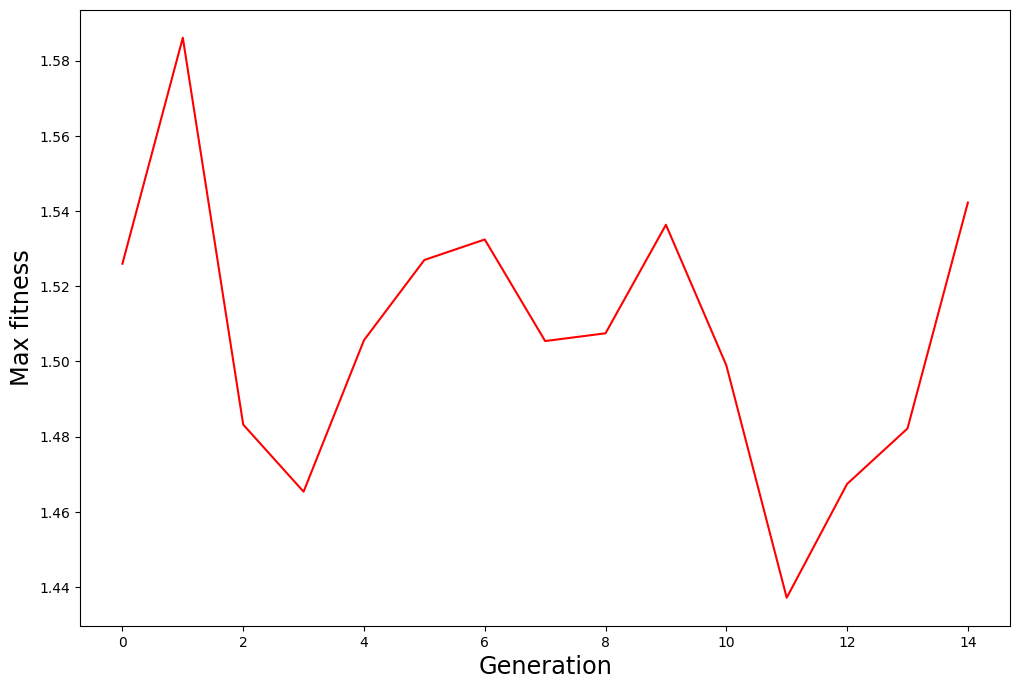

In [14]:
# Best fitness over time
plt.figure(figsize=(12,8))
plt.xlabel("Generation", size='xx-large')
plt.ylabel("Max fitness", size='xx-large')

plt.plot(range(len(fit_history)), fit_history, color='red')
plt.show()

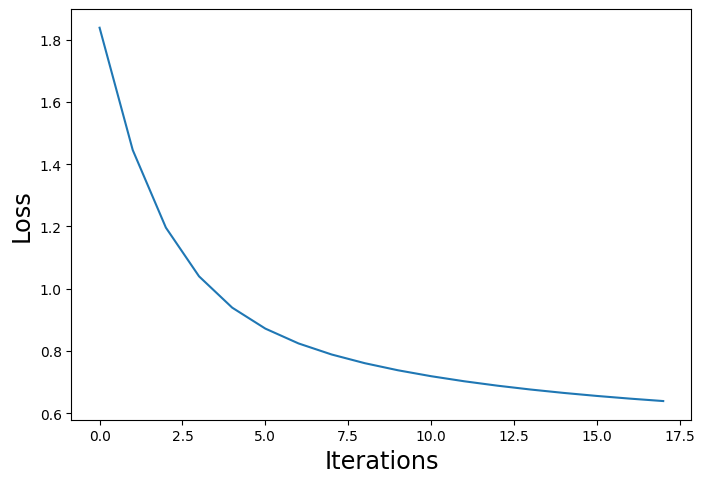

In [15]:
# Cost for a sample training run (to check learning rate)
plt.figure(figsize=(8,16/3))
plt.xlabel("Iterations", size='xx-large')
plt.ylabel("Loss", size='xx-large')
plt.plot(range(len(WARNING_GLOBAL_COST[3])), WARNING_GLOBAL_COST[3]) 

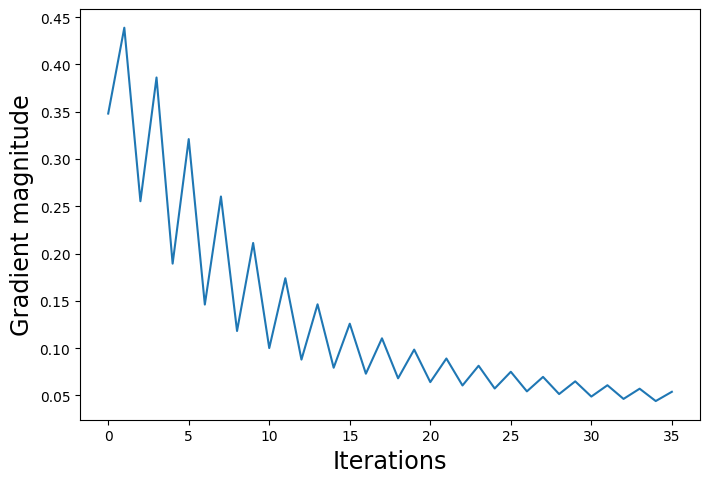

In [16]:
# Gradient size over time (to check epochs)
plt.figure(figsize=(8,16/3))
plt.xlabel("Iterations", size='xx-large')
plt.ylabel("Gradient magnitude", size='xx-large')
plt.plot(range(len(WARNING_GLOBAL_GRAD[0])), WARNING_GLOBAL_GRAD[0]) 

# Visualisation (Specific to Genetic Algorithm)

In [17]:
# Check most successful individuals
indiv_df = pd.DataFrame.from_dict(INDIV_STATS, orient='index').drop(['child_ids'], axis=1)
indiv_df = indiv_df.sort_values(by='children', ascending=False)
plot_df = indiv_df.head(15)
plot_df

,name,fitness,lifespan,children
110011111010011110011000100100010101001001010,Lizbeth Jazlyn,1.380340,22,34
110011111010011110011010100100010101001001010,Jade Ingrid,1.345614,17,32
001111110110000110000111010000000100000101000,Mila Laila,1.438258,18,26
100101111010011010001000000100010100100100101,Katelyn Melissa,1.041395,11,24
001110001010011010000111010000000100000101000,Nyla Laila,1.151091,11,20
001111110110000110000111010000100100000101000,Katie Jaylene,1.121597,16,16
001010000010011110000010100100010101110101010,Samantha Marilyn,1.186867,7,14
110011001010011110000010100100010101001001010,Irene Isabelle,1.115621,4,14
100101111010011010001000000100010101001001011,Melissa Kaylie,1.150523,5,12
110011101010011110001010100100010101001001010,Sara Isabelle,1.173284,4,10


Create a bar chart showing how successful different individuals were at reproducing

/tmp/ipykernel_20/2316502040.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  color_bar = plt.colorbar(sm, label='Fitness', cmap=colormap)
/tmp/ipykernel_20/2316502040.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_df['name'], rotation = 45, ha="right")


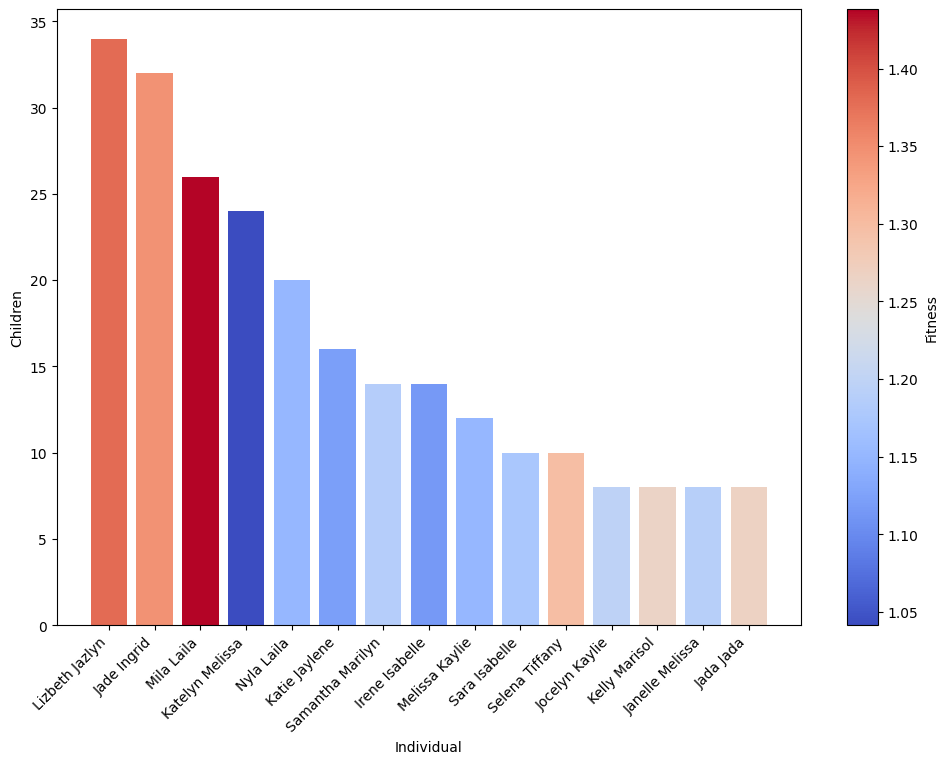

In [18]:
# Create figure
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# Create a colormap mapping fitness to colours
colormap = plt.get_cmap('coolwarm')
normalize = plt.Normalize(vmin=plot_df['fitness'].min(), vmax=plot_df['fitness'].max())
colours = colormap(normalize(plot_df['fitness']))

# Create the bar chart
bars = plt.bar(plot_df['name'], plot_df['children'], color=colours)

# Create legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])  # An empty array for the color bar
color_bar = plt.colorbar(sm, label='Fitness', cmap=colormap)

# Set labels and title
ax.set_xticklabels(plot_df['name'], rotation = 45, ha="right")

plt.xlabel('Individual')
plt.xticks(plot_df['name'])

plt.ylabel('Children')

# Show the plot
plt.show()

Create a directed graph showing the children of the most succesful individual 

In [19]:
def similarity(bitstr1 : str, bitstr2 : str) -> float:
    ''' Computes shared bits between two bitstrings '''
    
    sim = 0
    n_short = len(bitstr1) if len(bitstr1) <= len(bitstr2) else len(bitstr2)
    
    for i in range(n_short):
        sim += int( bitstr1[i] == bitstr2[i])
    
    return sim / n_short

In [20]:
def get_children(parent : str) -> list:
    ''' Gets children of parent node (specified by bitsring ID) '''
    
    child_ids = INDIV_STATS[parent]['child_ids']
    scale = 5.0
    edges = [(INDIV_STATS[parent]['name'], INDIV_STATS[c]['name'], scale * similarity(parent, c)) for c in child_ids]
    
    return edges

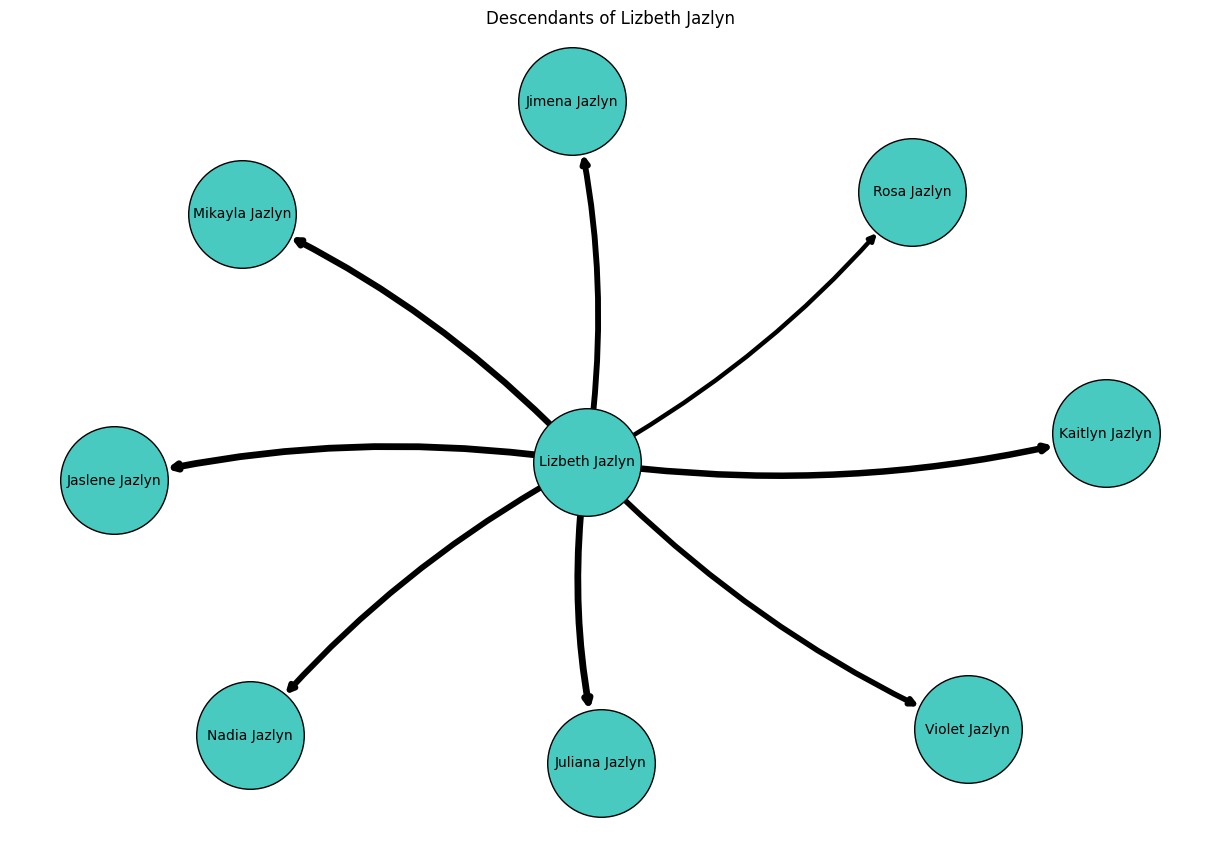

In [21]:
# Create figure
fig = plt.figure(figsize=(12,8))

# Convert data into directed network graph-able format
# First generation
top = plot_df.head(1).index[0]
child_ids = INDIV_STATS[top]['child_ids']
edges = get_children(top)

# Future generations (disabled for now due to small size)
for c in child_ids:
    new_edges = get_children(c)

# Build graph
G = nx.DiGraph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G)

# Draw nodes
nx.draw(G, pos, with_labels=True, node_color='#48CAC0', node_size=6000, font_size=10, font_color='black', width=[e[-1] for e in edges], arrows=True, connectionstyle="arc3,rad=0.1", edge_color='#000', edgecolors='#000')

plt.title(f"Descendants of {INDIV_STATS[top]['name']}")
plt.show()